# <font color='violet'> Exploration & Parsing
Using data wrangled here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/1-kl-wrangle-tabular.ipynb

In [1]:
# ! pip install tqdm 
# !{sys.executable} -m pip install contractions

In [2]:
import numpy as np
import pandas as pd
import sys
import contractions
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
# prepare to add local python functions; import modules from src directory
src = '../src'
sys.path.append(src)

# import local functions
from nlp.parse import remove_accented_chars, strip_most_punc, strip_apostrophe

In [4]:
df = pd.read_csv('../data/interim/studies_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50652 non-null  int64  
 1   drug        50652 non-null  object 
 2   rating      50652 non-null  float64
 3   condition   50652 non-null  object 
 4   review      50652 non-null  object 
 5   date        50652 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.3+ MB


In [5]:
# Drop "Unnamed" column; it's redundant with the index
df = df.drop(columns=['Unnamed: 0'])
df.head(2)

,drug,rating,condition,review,date
0,vyvanse,9.0,add,I had began taking 20mg of Vyvanse for three m...,0
1,dextroamphetamine,8.0,add,Switched from Adderall to Dexedrine to compare...,0


<font color='violet'> Explore each column, starting with 'drug'

In [6]:
# How many drugs are in the data? 
len(df.drug.unique())

651

In [18]:
# Which drugs are most commonly reviewed?
top_drugs = df.drug.value_counts().head(10)
top_drugs

Sertraline      1855
Escitalopram    1714
Citalopram      1298
Bupropion       1278
Lexapro         1232
Venlafaxine     1212
Varenicline     1082
Zoloft          1075
Quetiapine      1065
Clonazepam      1004
Name: drug, dtype: int64

It would be best to add a 'drug class' column when I come to feature engineering so that all these drugs are categorized. That column existed previously but came from one of the origina tables where too few of the rows had reviews for psych meds. I could eventually do this by creating a dictionary of drugs and their classes using information scraped from this website: https://www.drugs.com/drug-classes.html

Alternatively, drugs could be understood by the conditions they treat. 

<font color='violet'> Explore conditions

In [8]:
len(df.condition.unique())

38

In [32]:
top_conditions = df.condition.value_counts().head(10)
top_conditions

depression                  14425
anxiety                     14114
bipolar                      5604
addiction                    5192
insomnia                     5018
hrt                          1456
schizophrenia                 789
ocd                           752
other                         592
schizoaffective disorder      523
Name: condition, dtype: int64

In [33]:
# Which of the most common drugs are used to treat which of the most common conditions?

top_drugs = ['Sertraline', 'Escitalopram', 'Citalopram', 'Bupropion', 'Lexapro', 
             'Venlafaxine', 'Varenicline', 'Zoloft', 'Quetiapine', 'Clonazepam']
top_conditions = ['depression', 'anxiety', 'bipolar', 'addiction', 'insomnia', 'hrt',
                  'schizophrenia', 'ocd', 'other', 'schizoaffective disorder']
top_drug_conditions = df[df['drug'].isin(top_drugs) & df['condition'].isin(top_conditions)]

top_drug_conditions.head()

,drug,rating,condition,review,date
118,Clonazepam,10.0,anxiety,"""klonopin has definitely given me my life back...","April 19, 2008"
120,Escitalopram,9.0,depression,"""I am a 22 year old female college student. I ...","April 29, 2014"
124,Clonazepam,6.0,anxiety,"""Works for me""","March 24, 2013"
127,Zoloft,1.0,depression,"""Zoloft did not help me at all. I was on it f...","January 14, 2013"
129,Sertraline,10.0,depression,"""I had major depression from the time I starte...","November 2, 2014"


In [66]:
top_combo_summary = top_drug_conditions.pivot_table(index='condition', columns='drug', 
                                                    aggfunc='count', values='review')
top_combo_summary.columns = ['Sertraline', 'Escitalopram', 'Citalopram', 'Bupropion', 'Lexapro', 
             'Venlafaxine', 'Varenicline', 'Zoloft', 'Quetiapine', 'Clonazepam']
top_combo_summary = top_combo_summary.sort_values(by=['Sertraline', 'Escitalopram', 
                                                      'Citalopram', 'Bupropion', 'Lexapro', 
                                                      'Venlafaxine', 'Varenicline', 'Zoloft', 
                                                      'Quetiapine', 'Clonazepam'], 
                                                  ascending=False)
top_combo_summary

,Sertraline,Escitalopram,Citalopram,Bupropion,Lexapro,Venlafaxine,Varenicline,Zoloft,Quetiapine,Clonazepam
condition,,,,,,,,,,
depression,893.0,536.0,NaN,566.0,443.0,131.0,763.0,NaN,692.0,464.0
addiction,199.0,NaN,17.0,NaN,NaN,NaN,NaN,1079.0,NaN,NaN
anxiety,85.0,709.0,782.0,1061.0,751.0,100.0,841.0,NaN,432.0,441.0
bipolar,41.0,8.0,77.0,33.0,25.0,396.0,32.0,NaN,51.0,11.0
other,5.0,5.0,7.0,5.0,NaN,7.0,4.0,3.0,5.0,NaN
hrt,3.0,14.0,NaN,8.0,3.0,NaN,36.0,NaN,3.0,30.0
ocd,NaN,21.0,2.0,35.0,10.0,17.0,105.0,NaN,12.0,80.0
insomnia,NaN,NaN,103.0,NaN,NaN,243.0,NaN,NaN,NaN,NaN
schizoaffective disorder,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN


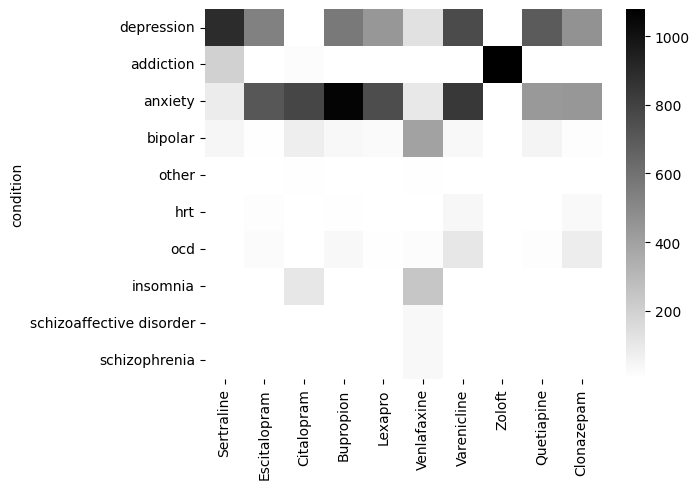

In [70]:
# Visualize distribution of reviews across common conditions & drugs with a heatmap.
sns.heatmap(top_combo_summary, cmap='gray_r')
plt.show()

In [41]:
help(pd.DataFrame.sort_values)

Help on function sort_values in module pandas.core.frame:

sort_values(self, by: 'IndexLabel', *, axis: 'Axis' = 0, ascending: 'bool | list[bool] | tuple[bool, ...]' = True, inplace: 'bool' = False, kind: 'str' = 'quicksort', na_position: 'str' = 'last', ignore_index: 'bool' = False, key: 'ValueKeyFunc' = None) -> 'DataFrame | None'
    Sort by the values along either axis.
    
    Parameters
    ----------
            by : str or list of str
                Name or list of names to sort by.
    
                - if `axis` is 0 or `'index'` then `by` may contain index
                  levels and/or column labels.
                - if `axis` is 1 or `'columns'` then `by` may contain column
                  levels and/or index labels.
    axis : {0 or 'index', 1 or 'columns'}, default 0
         Axis to be sorted.
    ascending : bool or list of bool, default True
         Sort ascending vs. descending. Specify list for multiple sort
         orders.  If this is a list of bools, must

<font color='violet'> Parse Language
    
   The review column contains narratives where patients explain their experience with a prescription psych med. Language features from that column need to be extracted or created after any necessary cleaning of strings has been completed. Do any preparations necessary to conduct sentiment analysis. I'll be drawing quite a bit from the following resource: 
    - https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

In [11]:
# View a sample string. Search for special characters.
df.review[0]

'I had began taking 20mg of Vyvanse for three months and was surprised to find that such a small dose affected my mood so effectively.  When it came to school work though I found that I needed the 30mg to increase my level of focus (and have been on it for a month since).  I had not experienced decreased appetite until about a month into taking the 20mg.  I find that the greatest benefit of Vyvanse for me is that it tends to stabalize my mood on a daily basis and lessens any bouts of anxiety and depression that i used to face before I was perscribed. a few experiences of nausiea, heavy moodswings on the days I do not take it, decreased appetite, and some negative affect on my short-term memory. My mood has noticably improved, I have more energy, experience better sleep and digestion.'

In [12]:
df[df['review'].str.find("é")!=-1].head(1)

,drug,rating,condition,review,date


In [13]:
df[df['review'].str.find("ä")!=-1].head(1)

,drug,rating,condition,review,date


<font color='violet'> Remove Special Characters

...if there are any. Haven't been able to find any of the most common special characters é or ä in the data, but doing it just in case. 

In [ ]:
# This function works in the test suite, but there may not be examples in the data
df['review'] = df['review'].apply(remove_accented_chars)

<font color='violet'> Expand Contractions

In [ ]:
# First, find some to confirm it works. 
df[df['review'].str.find("'")!=-1].head(1)

In [ ]:
df.review[9]

In [ ]:
df['review'] = df['review'].apply(contractions.fix)
df.review[9]

"Don't" got changed to "do not"; contraction expansion worked. 

<font color='violet'> Next, remove punctuation/special characters where appropriate. 
    
Try to keep those correlated with sentiment: ! ? # % ;) :( .  Again, first find an example to confirm it works.

In [ ]:
df[df['review'].str.find("!")!=-1].head(1)

In [ ]:
df.review[6]

In [ ]:
strip_most_punc(df, 'review')
df.review[6]

In [ ]:
# left to strip are ' and : ; () where they don't appear as emoji.

df[df['review'].str.find("'")!=-1].head(1)

In [ ]:
df.review[16]

In [ ]:
strip_apostrophe(df, 'review')
df.review[16]

In [ ]:
# apostrophes stripped successfully. Move onto final characters. 

# use regex to identify :;() when they appear next to a letter rather than in emoji.

# Then isolate just the symbol itself for removal
# https://pynative.com/python-find-position-of-regex-match-using-span-start-end/

<font color='violet'> Lemmatize text

<font color='violet'> More EDA

https://medium.com/plotly/nlp-visualisations-for-clear-immediate-insights-into-text-data-and-outputs-9ebfab168d5b
    
https://www.numpyninja.com/post/nlp-text-data-visualization
    
https://www.kaggle.com/code/sainathkrothapalli/nlp-visualisation-guide
    
https://medium.com/acing-ai/visualizations-in-natural-language-processing-2ca60dd34ce
    
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
    
https://towardsdatascience.com/getting-started-with-text-nlp-visualization-9dcb54bc91dd
    
https://www.kaggle.com/code/mitramir5/nlp-visualization-eda-glove
    
https://medium.com/analytics-vidhya/how-to-begin-performing-eda-on-nlp-ffdef92bedf6
    
https://inside-machinelearning.com/en/eda-nlp/
    
https://towardsdatascience.com/fundamental-eda-techniques-for-nlp-f81a93696a75
    
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
    
https://www.kdnuggets.com/2019/05/complete-exploratory-data-analysis-visualization-text-data.html
    
